In [1]:
import pandas as pd
df = pd.read_csv('leftfoot_freemocap_5min.csv')
df["datetime"] = pd.to_datetime(df["time"], format='ISO8601')
print(df.head())

        timestamp  com_right_foot_x  com_right_foot_y  com_right_foot_z  \
0  80984731656450       -131.819207        437.807048       1650.421200   
1  80984768285750       -131.436230        437.142920       1651.792637   
2  80984804356500       -131.161234        436.691145       1652.816794   
3  80984857611050       -131.213842        436.514692       1653.445923   
4  80984894285900       -131.297704        436.642029       1653.913199   

          t                         time        vx        vy        vz  \
0  0.000000         2025-12-04T15:41:06Z       NaN       NaN       NaN   
1  0.036629  2025-12-04T15:41:06.036629Z  0.010455 -0.018131  0.037441   
2  0.072700  2025-12-04T15:41:06.072700Z  0.007624 -0.012525  0.028393   
3  0.125955  2025-12-04T15:41:06.125955Z -0.000988 -0.003313  0.011814   
4  0.162629  2025-12-04T15:41:06.162629Z -0.002287  0.003472  0.012741   

         ax        ay        az   a_mag_g                         datetime  
0       NaN       NaN      

In [2]:
# RPE data with date + time
rpe_data = {
    "datetime": [
        "2025-12-04 15:41:00",
        "2025-12-04 15:42:00",
        "2025-12-04 15:43:00",
        "2025-12-04 15:44:00",
        "2025-12-04 15:45:00",
        "2025-12-04 15:46:00",
    ],
    "rpe": [2, 4, 6, 7, 9, 10]
}

rpe_df = pd.DataFrame(rpe_data)
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], format='ISO8601')
rpe_df["datetime"] = pd.to_datetime(rpe_df["datetime"], utc=True)
rpe_series = (
    rpe_df.set_index("datetime")["rpe"]
          .sort_index()
)

# 1-second timeline covering the RPE range
sec_index = pd.date_range(
    start=rpe_series.index.min(),
    end=rpe_series.index.max(),
    freq="1S",
    tz="UTC"
)

# Reindex + time interpolation -> per-second RPE curve
rpe_1s = (
    rpe_series.reindex(sec_index)
              .interpolate(method="time")
              .rename("rpe_interp")
              .to_frame()
              .reset_index()
              .rename(columns={"index": "datetime"})
)

rpe_1s.head(), rpe_1s.tail()

/tmp/ipykernel_17331/692455997.py:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sec_index = pd.date_range(


(                   datetime  rpe_interp
 0 2025-12-04 15:41:00+00:00    2.000000
 1 2025-12-04 15:41:01+00:00    2.033333
 2 2025-12-04 15:41:02+00:00    2.066667
 3 2025-12-04 15:41:03+00:00    2.100000
 4 2025-12-04 15:41:04+00:00    2.133333,
                      datetime  rpe_interp
 296 2025-12-04 15:45:56+00:00    9.933333
 297 2025-12-04 15:45:57+00:00    9.950000
 298 2025-12-04 15:45:58+00:00    9.966667
 299 2025-12-04 15:45:59+00:00    9.983333
 300 2025-12-04 15:46:00+00:00   10.000000)

In [3]:
# df columns: datetime (UTC-aware), a_mag_g
df = df.sort_values("datetime").copy()
df["sec"] = df["datetime"].dt.floor("S")

acc_1s = (
    df.groupby("sec")["a_mag_g"]
      .agg(
          mean_acc="mean",
          rms_acc=lambda x: (x**2).mean()**0.5,
          std_acc="std",
          p95_acc=lambda x: x.quantile(0.95),
      )
      .reset_index()
      .rename(columns={"sec": "datetime"})
)

acc_1s.head()


/tmp/ipykernel_17331/770739682.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["sec"] = df["datetime"].dt.floor("S")


,datetime,mean_acc,rms_acc,std_acc,p95_acc
0,2025-12-04 15:41:06+00:00,1.393302,1.447821,0.407380,2.133053
1,2025-12-04 15:41:07+00:00,1.960790,2.063338,0.662161,2.824864
2,2025-12-04 15:41:08+00:00,2.155668,2.161510,0.194503,2.336589
3,2025-12-04 15:41:09+00:00,2.144487,2.200232,0.539104,2.738395
4,2025-12-04 15:41:10+00:00,1.729970,1.731901,0.094416,1.839897


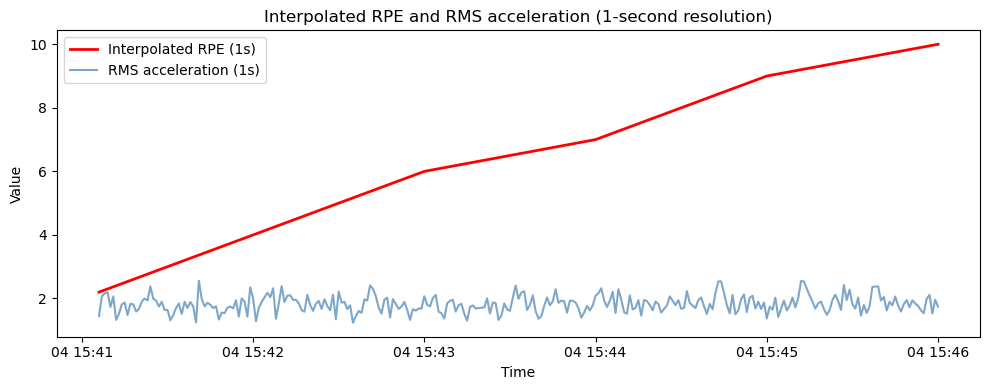

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(
    exp_df["datetime"],
    exp_df["rpe_interp"],
    label="Interpolated RPE (1s)",
    color="red",
    linewidth=2
)

plt.plot(
    exp_df["datetime"],
    exp_df["rms_acc"],
    label="RMS acceleration (1s)",
    color="steelblue",
    alpha=0.7
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Interpolated RPE and RMS acceleration (1-second resolution)")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
exp_df = pd.merge(rpe_1s, acc_1s, on="datetime", how="inner")
exp_df = exp_df.dropna()

print(exp_df.shape)
exp_df[["datetime", "rpe_interp", "rms_acc"]].head()


(289, 6)


,datetime,rpe_interp,rms_acc
0,2025-12-04 15:41:06+00:00,2.200000,1.447821
1,2025-12-04 15:41:07+00:00,2.233333,2.063338
2,2025-12-04 15:41:08+00:00,2.266667,2.161510
3,2025-12-04 15:41:09+00:00,2.300000,2.200232
4,2025-12-04 15:41:10+00:00,2.333333,1.731901


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X = exp_df[["rms_acc"]]
y = exp_df["rpe_interp"]

m = LinearRegression().fit(X, y)
pred = m.predict(X)

print("R2:", r2_score(y, pred))
print("MAE:", mean_absolute_error(y, pred))
print("coef:", m.coef_, "intercept:", m.intercept_)


R2: 0.009159557658158679
MAE: 1.8984827729257963
coef: [0.82504648] intercept: 4.9663348366705895


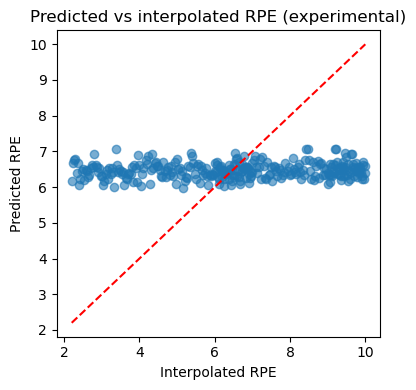

In [7]:
plt.figure(figsize=(4, 4))

plt.scatter(exp_df["rpe_interp"], pred, alpha=0.6)
plt.plot(
    [exp_df["rpe_interp"].min(), exp_df["rpe_interp"].max()],
    [exp_df["rpe_interp"].min(), exp_df["rpe_interp"].max()],
    "r--"
)

plt.xlabel("Interpolated RPE")
plt.ylabel("Predicted RPE")
plt.title("Predicted vs interpolated RPE (experimental)")
plt.tight_layout()
plt.show()
